In [1]:
from google.cloud import bigquery
import gc
import pandas as pd
import numpy as np
import datetime
import os
import json
from haversine import haversine
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/mnt/clients/juba/hqjubaapp02/sharefolder/GoodYear/docs/merkle-gdyr-prod-9783607c77a1.json"

zip_centers=json.load(open("/mnt/clients/juba/hqjubaapp02/sharefolder/Docs/Geo_mapping/updated_zip_centers_JL_2019-05-23.json"))
client = bigquery.Client()

print(datetime.datetime.now())
print(os.getcwd())

2020-10-28 21:48:13.613856
/mnt/clients/juba/hqjubaapp02/sharefolder/GoodYear/jian/Selections


In [2]:
query_string='''
select indiv_key, store_id, extract(date from invoice_date) as trans_date, sum(qty) as daily_qty from mdb.trn_detail \
where product_type_cd='TIRE' \
group by indiv_key, store_id, trans_date;
'''
df_1=client.query(query_string).result().to_dataframe()
print(df_1.shape)

df_1=df_1[df_1['daily_qty']>1]
print(df_1.shape)


/home/jliang/.local/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


(6415564, 4)
(4150228, 4)


In [3]:
df_1.head(2)

,indiv_key,store_id,trans_date,daily_qty
0,1.222781e+15,2537,2020-10-13,16
1,1.222780e+15,2264,2015-05-21,6


In [4]:
df_1['indiv_key'][0]

1222780625002823.0

In [5]:
df_2=df_1.groupby("indiv_key")['trans_date'].count().to_frame().reset_index()
df_2=df_2[(df_2['trans_date']>=2) & (df_2['trans_date']<=6)]
df_2=df_2.rename(columns={"trans_date":"total_trans_day_1plusTIRE"})
print(df_2.shape)
df_2.head(2)

(654890, 2)


,indiv_key,total_trans_day_1plusTIRE
1,1.222780e+15,2
2,1.222780e+15,2


In [7]:
df_id_by_tire_trans=pd.merge(df_2,df_1,on="indiv_key",how="left")
print(df_id_by_tire_trans.shape)

df_id_by_tire_trans.head(2)

(1680992, 5)


,indiv_key,total_trans_day_1plusTIRE,store_id,trans_date,daily_qty
0,1.222780e+15,2,ECOM,2018-05-14,2
1,1.222780e+15,2,2460,2016-06-07,4


In [9]:
df_id_by_tire_trans['trans_date'][0]

datetime.date(2018, 5, 14)

In [10]:
df_id_by_tire_trans['indiv_key'].nunique()

654890

In [11]:
a=df_id_by_tire_trans.groupby('indiv_key')['store_id'].count().to_frame().reset_index()
a['store_id'].min(),a['store_id'].max()

(2, 6)

In [12]:
df_id_by_tire_trans_2to3=df_id_by_tire_trans[df_id_by_tire_trans['daily_qty']<4]
print(df_id_by_tire_trans_2to3['daily_qty'].min())

df_id_by_tire_trans_4_plus=df_id_by_tire_trans[df_id_by_tire_trans['daily_qty']>=4]

2


In [13]:
print(df_id_by_tire_trans_2to3.shape,df_id_by_tire_trans_2to3['indiv_key'].nunique())
print(df_id_by_tire_trans_4_plus.shape,df_id_by_tire_trans_4_plus['indiv_key'].nunique())

(746184, 5) 407264
(934808, 5) 482917


In [14]:
def remove_1trans_only_ids(df_input):
    df_grouped_by=df_input.groupby("indiv_key")['store_id'].count().to_frame().reset_index()
    list_1trans_only=df_grouped_by[df_grouped_by['store_id']==1]['indiv_key'].tolist()
    print("%i ids with 1 trans only removed"%len(list_1trans_only))
    df_output=df_input[~df_input['indiv_key'].isin(list_1trans_only)]
    return df_output

df_id_by_tire_trans_2to3=remove_1trans_only_ids(df_id_by_tire_trans_2to3)
df_id_by_tire_trans_4_plus=remove_1trans_only_ids(df_id_by_tire_trans_4_plus)

print(df_id_by_tire_trans_2to3.shape,df_id_by_tire_trans_2to3['indiv_key'].nunique())
print(df_id_by_tire_trans_4_plus.shape,df_id_by_tire_trans_4_plus['indiv_key'].nunique())

154958 ids with 1 trans only removed
161588 ids with 1 trans only removed
(591226, 5) 252306
(773220, 5) 321329


In [15]:
df_id_by_tire_trans_2to3=df_id_by_tire_trans_2to3.sort_values(['indiv_key','trans_date'],ascending=[True,True])
df_id_by_tire_trans_2to3['val']=1
df_id_by_tire_trans_2to3['trans_order']=df_id_by_tire_trans_2to3.groupby('indiv_key')['val'].cumsum()
del df_id_by_tire_trans_2to3['val']

list_more_trans_2to3=df_id_by_tire_trans_2to3[df_id_by_tire_trans_2to3['trans_order']>3]['indiv_key'].tolist()
print("list_more_trans_2to3: %d"%len(list_more_trans_2to3))
df_id_by_tire_trans_2to3=df_id_by_tire_trans_2to3[~df_id_by_tire_trans_2to3['indiv_key'].isin(list_more_trans_2to3)]
print(df_id_by_tire_trans_2to3.shape,df_id_by_tire_trans_2to3['indiv_key'].nunique())
df_id_by_tire_trans_2to3.head(2)

list_more_trans_2to3: 24896
(509555, 6) 233381


,indiv_key,total_trans_day_1plusTIRE,store_id,trans_date,daily_qty,trans_order
26,1.222780e+15,3,2332,2016-05-25,2,1
27,1.222780e+15,3,2332,2017-09-17,2,2


In [16]:
df_id_by_tire_trans_4_plus=df_id_by_tire_trans_4_plus.sort_values(['indiv_key','trans_date'],ascending=[True,True])
df_id_by_tire_trans_4_plus['val']=1
df_id_by_tire_trans_4_plus['trans_order']=df_id_by_tire_trans_4_plus.groupby('indiv_key')['val'].cumsum()
del df_id_by_tire_trans_4_plus['val']

list_more_trans_4_plus=df_id_by_tire_trans_4_plus[df_id_by_tire_trans_4_plus['trans_order']>3]['indiv_key'].tolist()
print("list_more_trans_4_plus: %d"%len(list_more_trans_4_plus))
df_id_by_tire_trans_4_plus=df_id_by_tire_trans_4_plus[~df_id_by_tire_trans_4_plus['indiv_key'].isin(list_more_trans_4_plus)]
print(df_id_by_tire_trans_4_plus.shape,df_id_by_tire_trans_4_plus['indiv_key'].nunique())
df_id_by_tire_trans_4_plus.head(2)

list_more_trans_4_plus: 40118
(646039, 6) 292308


,indiv_key,total_trans_day_1plusTIRE,store_id,trans_date,daily_qty,trans_order
2,1.222780e+15,2,6836,2018-02-24,4,1
3,1.222780e+15,2,6836,2018-02-28,4,2


In [17]:
list_more_trans_all=list_more_trans_4_plus+list_more_trans_2to3
df_id_by_tire_trans=df_id_by_tire_trans[~df_id_by_tire_trans['indiv_key'].isin(list_more_trans_all)]
print(df_id_by_tire_trans.shape,df_id_by_tire_trans['indiv_key'].nunique())

# If a person shopped a 2-3 tires once, and a 4+ tires once. They are included
# But if a person shopped more than 3 times of either 2-3 tires or 4+tires, they are removed

df_id_by_tire_trans=df_id_by_tire_trans.sort_values(['indiv_key','trans_date'],ascending=[True,True])
df_id_by_tire_trans['val']=1
df_id_by_tire_trans['trans_order']=df_id_by_tire_trans.groupby('indiv_key')['val'].cumsum()
del df_id_by_tire_trans['val']

print(df_id_by_tire_trans.shape,df_id_by_tire_trans['indiv_key'].nunique())
df_id_by_tire_trans.head(2)


(1452276, 5) 606944
(1452276, 6) 606944


,indiv_key,total_trans_day_1plusTIRE,store_id,trans_date,daily_qty,trans_order
1,1.222780e+15,2,2460,2016-06-07,4,1
0,1.222780e+15,2,ECOM,2018-05-14,2,2


In [22]:
def generate_df_with_interval(df_input):
    df_output=df_input[['indiv_key','total_trans_day_1plusTIRE']].drop_duplicates()

    df_id_by_tire_trans_1=df_input[df_input['trans_order']==1]
    df_id_by_tire_trans_1=df_id_by_tire_trans_1[['indiv_key','store_id','trans_date']].drop_duplicates().rename(columns={"store_id":"trans_1st_store","trans_date":"trans_1st_date"})

    df_id_by_tire_trans_2=df_input[df_input['trans_order']==2]
    df_id_by_tire_trans_2=df_id_by_tire_trans_2[['indiv_key','store_id','trans_date']].drop_duplicates().rename(columns={"store_id":"trans_2nd_store","trans_date":"trans_2nd_date"})

    df_id_by_tire_trans_3=df_input[df_input['trans_order']==3]
    df_id_by_tire_trans_3=df_id_by_tire_trans_3[['indiv_key','store_id','trans_date']].drop_duplicates().rename(columns={"store_id":"trans_3rd_store","trans_date":"trans_3rd_date"})

    df_output=pd.merge(df_output,df_id_by_tire_trans_1,on="indiv_key",how="left")
    df_output=pd.merge(df_output,df_id_by_tire_trans_2,on="indiv_key",how="left")
    df_output=pd.merge(df_output,df_id_by_tire_trans_3,on="indiv_key",how="left")
    
    df_output['diff_day_1_2']=(df_output['trans_2nd_date']-df_output['trans_1st_date']).dt.days
    df_output['diff_day_2_3']=np.where(pd.isnull(df_output['trans_3rd_date']),np.nan,
                                        (df_output['trans_3rd_date']-df_output['trans_2nd_date']).dt.days)


    df_output['diff_month_1_2']=np.round((df_output['trans_2nd_date']-df_output['trans_1st_date']).dt.days/30,4)
    df_output['diff_month_2_3']=np.where(pd.isnull(df_output['trans_3rd_date']),np.nan,
                                        np.round((df_output['trans_3rd_date']-df_output['trans_2nd_date']).dt.days/30,4))


    return df_output
    

In [23]:
df_output_2to3=generate_df_with_interval(df_id_by_tire_trans_2to3)
df_output_4_plus=generate_df_with_interval(df_id_by_tire_trans_4_plus)
df_output_all=generate_df_with_interval(df_id_by_tire_trans)

In [24]:
def write_summary_frequency(df_input_with_interval_float,out_file_name):
    writer=pd.ExcelWriter("./%s"%out_file_name,engine="xlsxwriter")
    print(os.getcwd())
    df_output_summary_day_1_2=df_input_with_interval_float.groupby("diff_day_1_2")['indiv_key'].count().to_frame().reset_index()
    df_output_summary_day_2_3=df_input_with_interval_float.groupby("diff_day_2_3")['indiv_key'].count().to_frame().reset_index()

    df_output_copy=df_input_with_interval_float[['indiv_key','diff_month_1_2','diff_month_2_3']]
    df_output_copy['diff_ceil_month_1_2']=np.ceil(df_output_copy['diff_month_1_2']).astype(int)
    df_output_copy['diff_ceil_month_2_3']=df_output_copy['diff_month_2_3'].apply(lambda x: int(np.ceil(x)) if pd.notnull(x) else x)
    
    df_output_summary_month_1_2=df_output_copy.groupby("diff_ceil_month_1_2")['indiv_key'].count().to_frame().reset_index()
    df_output_summary_month_2_3=df_output_copy.groupby("diff_ceil_month_2_3")['indiv_key'].count().to_frame().reset_index()
    
    df_input_with_interval_float.head(1000).to_excel(writer,"sample_1000",index=False)
    df_output_summary_month_1_2.to_excel(writer,"month_interval_1_2",index=False)
    df_output_summary_month_2_3.to_excel(writer,"month_interval_2_3",index=False)
    df_output_summary_day_1_2.to_excel(writer,"day_interval_1_2",index=False)
    df_output_summary_day_2_3.to_excel(writer,"day_interval_2_3",index=False)
    
    plt_month_1_2 = df_input_with_interval_float[['diff_month_1_2']].plot.hist(bins=50, alpha=0.5)
    plt_month_2_3 = df_input_with_interval_float[['diff_month_2_3']].plot.hist(bins=50, alpha=0.5)
    
    writer.save()
    # return df_output_summary_day_1_2,df_output_summary_day_2_3,df_output_summary_month_1_2,df_output_summary_month_2_3

/mnt/clients/juba/hqjubaapp02/sharefolder/GoodYear/jian/Selections


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


/mnt/clients/juba/hqjubaapp02/sharefolder/GoodYear/jian/Selections


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


/mnt/clients/juba/hqjubaapp02/sharefolder/GoodYear/jian/Selections


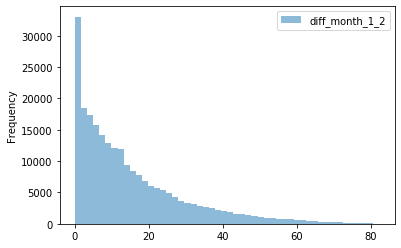

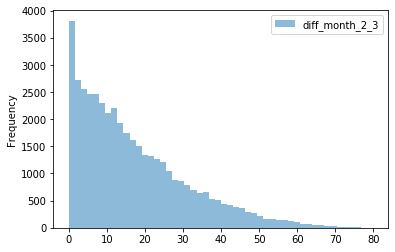

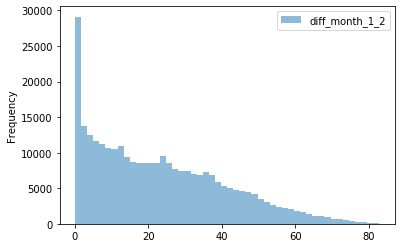

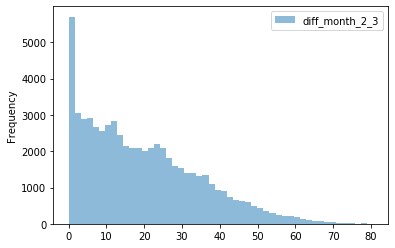

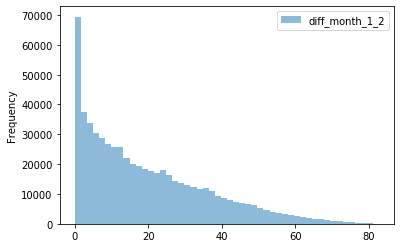

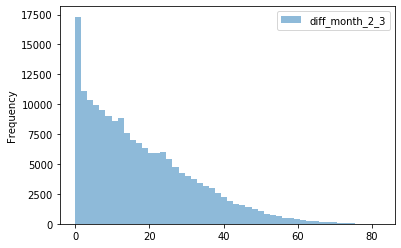

In [25]:
write_summary_frequency(df_output_2to3,"GY_2to3_tire_shop_month_interval_freq_summary_JL_%s.xlsx"%str(datetime.datetime.now().date()))
write_summary_frequency(df_output_4_plus,"GY_4_plus_tire_shop_month_interval_freq_summary_JL_%s.xlsx"%str(datetime.datetime.now().date()))
write_summary_frequency(df_output_all,"GY_2to6_plus_tire_shop_month_interval_freq_summary_JL_%s.xlsx"%str(datetime.datetime.now().date()))


In [26]:
df_input_with_interval_float=df_output_2to3.copy()

df_output_summary_day_1_2=df_input_with_interval_float.groupby("diff_day_1_2")['indiv_key'].count().to_frame().reset_index()
df_output_summary_day_2_3=df_input_with_interval_float.groupby("diff_day_2_3")['indiv_key'].count().to_frame().reset_index()

df_output_copy=df_input_with_interval_float[['indiv_key','diff_month_1_2','diff_month_2_3']]
df_output_copy['diff_ceil_month_1_2']=np.ceil(df_output_copy['diff_month_1_2']).astype(int)
df_output_copy['diff_ceil_month_2_3']=df_output_copy['diff_month_2_3'].apply(lambda x: int(np.ceil(x)) if pd.notnull(x) else x)

df_output_summary_month_1_2=df_output_copy.groupby("diff_ceil_month_1_2")['indiv_key'].count().to_frame().reset_index()
df_output_summary_month_2_3=df_output_copy.groupby("diff_ceil_month_2_3")['indiv_key'].count().to_frame().reset_index()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
df_output_copy[df_output_copy['diff_ceil_month_1_2']==0].shape

(196, 5)

In [29]:
df_output_copy[df_output_copy['diff_ceil_month_2_3']==0].shape

(13, 5)

In [32]:
df_output_copy[df_output_copy['diff_ceil_month_1_2']==0]['indiv_key'].tolist()[0]

1222780023000254.0

In [33]:
df=df_id_by_tire_trans_2to3[df_id_by_tire_trans_2to3['indiv_key']==1222780023000254]
del df['trans_order']
df.drop_duplicates().shape

(3, 5)

In [34]:
df

,indiv_key,total_trans_day_1plusTIRE,store_id,trans_date,daily_qty
30806,1.222780e+15,3,2363,2015-02-02,2
30808,1.222780e+15,3,2382,2015-02-02,2
30807,1.222780e+15,3,2391,2017-09-21,2
